In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import pandas as pd
import shapely
from shapely.geometry import LineString
from shapely import MultiPoint
from shapely.geometry import MultiLineString
import datetime
import numpy as np
import rasterio as rio
from rasterio import plot as rioplot
from rasterio import warp
from pyproj import CRS

from utils import add_graticule

Clip Spatial

In [17]:
# specify the cycle here
cycle = 21

# read in the files
kml_file = '/home/jovyan/shared-public/ICESat-2-Hackweek/ground_tracks/cycle%02i_1hz_points.pkl' % cycle
search_file = 'search_circle_ll.geojson'
geo_kml = pd.read_pickle(kml_file)
geo_search = gpd.GeoDataFrame.from_file(search_file)

# buffer the search polygon by 10km 
geo_buffer = geo_search.copy()
center = geo_buffer.geometry.iloc[0].centroid
crs_local = CRS("+proj=stere +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(center.y, center.x))
geo_buffer = geo_buffer.to_crs(crs_local)
geo_buffer['geometry'] = shapely.buffer(geo_buffer.to_crs(crs_local).geometry.iloc[0], 10000)
geo_buffer = geo_buffer.to_crs('epsg:4326')

# Clip gdf 'geo_kml' of kmls with gdf 'geo_buffer' of buffered AOI (circle polygon)
geo_clipped_df = gpd.clip(geo_kml, geo_buffer).copy()
geo_clipped_df.sort_values(by='timestamp', inplace=True)
geo_clipped_df.reset_index(inplace=True, drop=True)

In [24]:
# add linestrings to the file
# linestrings = geo_clipped_df.groupby(['rgt'])['lat','lon'].apply(lambda x: LineString(list(zip(x.lon.tolist(),x.lat.tolist()))))
# times = geo_clipped_df.groupby(by='rgt')['timestamp'].mean()
# dflines = gpd.GeoDataFrame(times, geometry=linestrings, crs="EPSG:4326")
# dflines['time_str'] = [datetime.datetime.strftime(datetime.datetime.fromtimestamp(t), '%a %Y-%b-%d %H:%M:%S') for t in dflines.timestamp]
# dflines.reset_index(inplace=True)

# add the initial search area
geo = geo_search.copy()
geo['rgt'] = 'none'
geo['timestamp'] = 0
geo['time_str'] = 'none'

df_out = geo.copy()
df_out.reset_index(inplace=True, drop=True)
# df_out.explore()

In [20]:
# get the beam pairs
geo_clipped = geo_clipped_df.copy()
crs_lonlat = CRS('epsg:4326')
distances = [-3345, -3255, -45, 45, 3255, 3345]
spots = ['1l', '1r', '2l', '2r', '3l', '3r']

for rgt in np.unique(geo_clipped.rgt):
    
    df_rgt = geo_clipped[geo_clipped.rgt == rgt]
    n_pts = len(df_rgt)
    
    for i in range(n_pts):
        
        # get the locally centered CRS from this point
        thispt = df_rgt.iloc[i]
        cust = CRS("+proj=stere +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(thispt.lat, thispt.lon))
        
        # get the surrounding points and transform
        edges = np.clip(np.array([i-1, i+1]), 0, n_pts-1)
        thisdata = df_rgt.iloc[edges[0]:edges[1]+1,:]
        
        xydata = thisdata.to_crs(cust)
        
        dx = xydata.iloc[-1].geometry.x - xydata.iloc[0].geometry.x
        dy = xydata.iloc[-1].geometry.y - xydata.iloc[0].geometry.y
        normal = np.array([-dy, dx])
        unit_normal = normal / np.linalg.norm(normal)
        
        xs, ys = [0.0], [0.0]
        for d in distances:
            xy = d * unit_normal
            xs.append(xy[0])
            ys.append(xy[1])
            
        thisdf = df_rgt.iloc[[i]].to_crs(cust)
        thisdf['geometry'] = MultiPoint(np.transpose(np.array([xs,ys])))
        resultdf = thisdf.to_crs('epsg:4326')
        geo_clipped.loc[thispt.name,'geometry'] = resultdf.iloc[0].geometry
        
# put the multipoints into data frame columns
spots = ['1l', '1r', '2l', '2r', '3l', '3r']
columns = np.array([[s+'_lon', s+'_lat'] for s in spots]).flatten()
geo_clipped[columns] = np.nan
for i in range(len(geo_clipped)):
    x = geo_clipped.iloc[i]
    pts = np.array([(x.geometry.geoms[j].x, x.geometry.geoms[j].y) for j in range(len(x.geometry.geoms))]).flatten()
    geo_clipped.loc[x.name, columns] = pts[2:]

In [21]:
# add linestrings for the beams
def get_linestrings(df):
    linestringlist = [list(zip(df.lon.tolist(),df.lat.tolist()))]
    for s in spots:
        linestringlist.append(list(zip(df['%s_lon'%s].tolist(),df['%s_lat'%s].tolist())))
    return MultiLineString(linestringlist)
times = geo_clipped.groupby(['rgt'])[['timestamp']].mean()
geom = geo_clipped.groupby(['rgt']).apply(get_linestrings)
df_beamlines = gpd.GeoDataFrame(times, geometry=geom, crs="EPSG:4326")
df_beamlines.reset_index(inplace=True)
df_beamlines['time_str'] = [datetime.datetime.strftime(datetime.datetime.fromtimestamp(t), '%a %Y-%b-%d %H:%M:%S') for t in df_beamlines.timestamp]

In [51]:
# combine all the outputs into one geodataframe
df_output = pd.concat((df_out, df_beamlines, geo_clipped[df_out.keys()]))
df_output = gpd.clip(df_output, geo_search).copy()
df_output.sort_values(by='timestamp', inplace=True)
df_output.iloc[1:,:].explore()

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/tools/clip.py:67: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


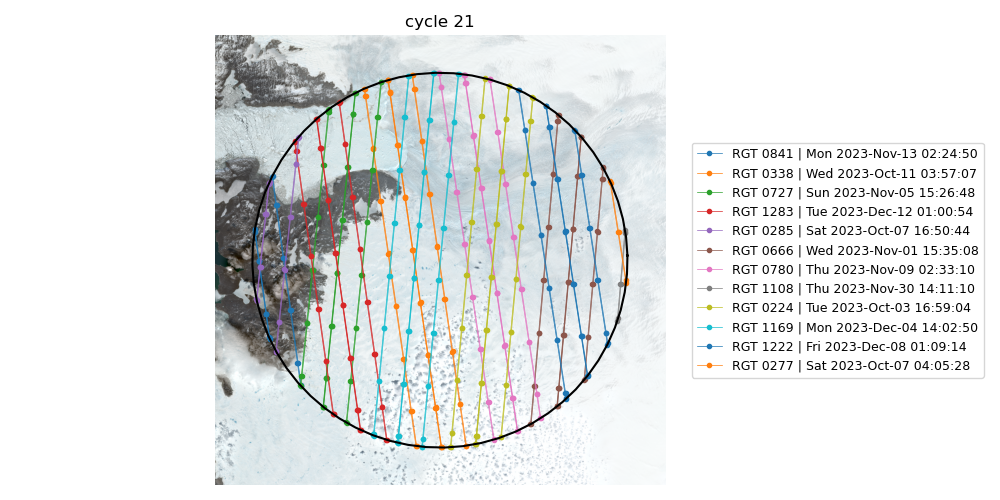

In [48]:
# plot the example (over a Sentinel-2 mosaic generated over the example area)
df_plot = gpd.clip(df_beamlines, geo_search).copy()
imgfn = '/home/jovyan/shared-public/ICESat-2-Hackweek/ground_tracks/s2mosaic.tif'
img = rio.open(imgfn)
fig, ax = plt.subplots(figsize=[10,5])
rioplot.show(img, ax=ax);
crs_plot = img.crs

# plot gound tracks and beams
hdls = []
for j, rgt in enumerate(df_plot.rgt):
    thisrgt = df_plot.iloc[j]
    for i in range(len(thisrgt.geometry.geoms)):
        lonlat = thisrgt.geometry.geoms[i].coords.xy
        gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=lonlat[0], ys=lonlat[1])
        hdl, = ax.plot(gtx_x,gtx_y,marker='o',lw=0.5,ms=3,c='C%i'%j,label='RGT %04i | %s' % (thisrgt.rgt, thisrgt.time_str))
    hdls.append(hdl)
    
# plot area of intererst
x, y = geo.iloc[0].geometry.exterior.xy
bound_x, bound_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=x,ys=y)
ax.plot(bound_x, bound_y, c="k")

# figure adjustment things
xr = np.max(bound_x) - np.min(bound_x)
yr = np.max(bound_y) - np.min(bound_y)
fac = 0.1
ax.set_xlim((np.min(bound_x)-fac*xr, np.max(bound_x)+fac*xr))
ax.set_ylim((np.min(bound_y)-fac*yr, np.max(bound_y)+fac*yr))
ax.axis('off')
ax.legend(handles = hdls, bbox_to_anchor=(1.06, 0.5), loc="center left", borderaxespad=0, fontsize=9)
ax.set_title('cycle %i' % cycle)
fig.tight_layout()

fig.savefig('example_plot_buffered.jpg', dpi=600)

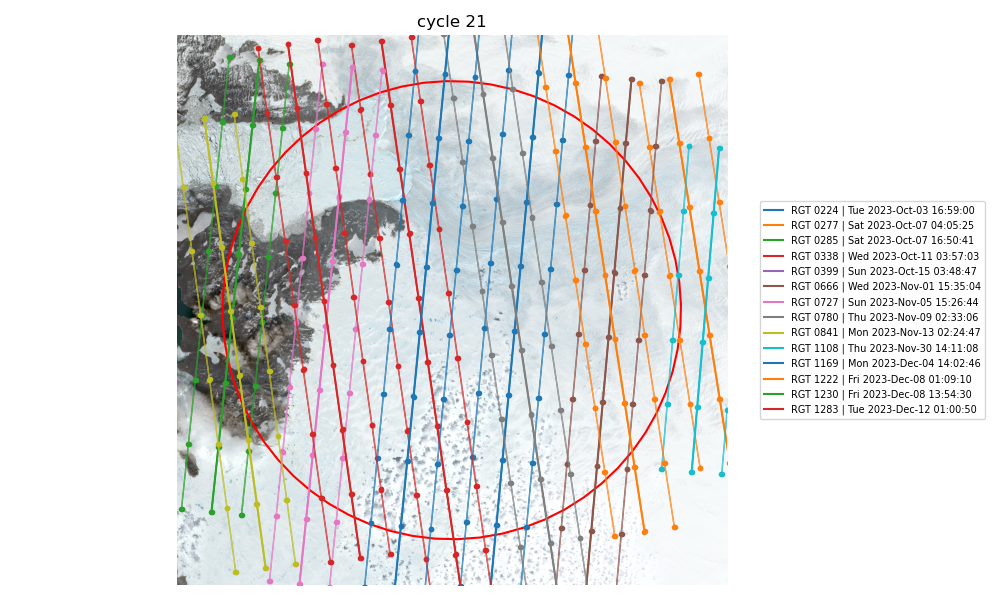

In [23]:
# plot the example (over a Sentinel-2 mosaic generated over the example area)
imgfn = '/home/jovyan/shared-public/ICESat-2-Hackweek/ground_tracks/s2mosaic.tif'
img = rio.open(imgfn)
fig, ax = plt.subplots(figsize=[10,6])
rioplot.show(img, ax=ax);
crs_plot = img.crs

# plot area of intererst
x, y = df_ex.iloc[0].geometry.exterior.xy
bound_x, bound_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=x,ys=y)
ax.plot(bound_x, bound_y, c="red")

# plot gound tracks and beams
hdls = []
for j, rgt in enumerate(np.unique(geo_clipped.rgt)):
    df_rgt = geo_clipped[geo_clipped.rgt == rgt]
    gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=np.array(df_rgt.lon), ys=np.array(df_rgt.lat))
    hdl, = ax.plot(gtx_x,gtx_y,c='C%i'%j, label='RGT %04i | %s' % (df_rgt.rgt.iloc[0], df_rgt.time_str.iloc[0]))
    hdls.append(hdl)
    for i,s in enumerate(spots):
        gtx_x, gtx_y = warp.transform(src_crs='epsg:4326', dst_crs=crs_plot, xs=np.array(df_rgt['%s_lon'%s]),ys=np.array(df_rgt['%s_lat'%s]))
        ax.plot(gtx_x,gtx_y,marker='o',lw=0.5,ms=3,c='C%i'%j)

# figure adjustment things
xr = np.max(bound_x) - np.min(bound_x)
yr = np.max(bound_y) - np.min(bound_y)
fac = 0.1
ax.set_xlim((np.min(bound_x)-fac*xr, np.max(bound_x)+fac*xr))
ax.set_ylim((np.min(bound_y)-fac*yr, np.max(bound_y)+fac*yr))
ax.axis('off')
ax.legend(handles = hdls, bbox_to_anchor=(1.06, 0.5), loc="center left", borderaxespad=0, fontsize=7)
ax.set_title('cycle %i' % cycle)
fig.tight_layout()

fig.savefig('example_plot.jpg', dpi=600)